# Machine Learning Models

After conducting our analysis and getting a better feel for the dialogue tendencies across justices, genders, ages, and time, we are ready to create some machine learning models. We were most curious about making the following models: 

Models about the justices:
- Predicting gender of the speaker of a text block from text.
- Predicting gender of the speaker from linguistic features, interruption count, and sentiment analysis. 
- Predicting the justice of a text block from linguistic features, interruption count,  and sentiment analysis.

Models about the court case:
- Predicting whether or not each justice agrees or disagrees with the majority decision based on their dialogue throughout the case. 

Generators:
- Generated dialogue for any Justice based on everything they said in a Supreme Court Case since 2005.

# Predicting Gender From Text

Let's start with a basic gender prediction model with using the text blocks as a feature. We will use 10 fold cross validation with a weighted f1 score to optimize our model, and then create a classification report using cross validation.

In [1]:
import warnings
warnings.filterwarnings('ignore')

We will use the following data set from our analysis, with each row representing a justice's turn speaking since 2005. Each row has the linguistic features that we found from the analysis.

In [81]:
import pandas as pd
justices = pd.read_csv("justices_sentiment.csv")

Note: Because our data set was so large, we optimized it and estimated test error based on a random sample.

In [3]:
justices_mini = justices.sample(frac=0.001)
X_train = justices_mini["text_blocks"]
y_train = justices_mini["gender"]

Let's pick some arbitrary values of m and k to make a base model that we will then optimize.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler

vec = CountVectorizer(max_features = 50)
model = KNeighborsClassifier(n_neighbors = 10)
tfidf = TfidfTransformer()

pipeline = Pipeline([
    ("vec", vec),
    ("tfidf", tfidf),
    ("model", model)
])

cross_val_score(pipeline, X_train, y_train, 
                cv=10, scoring="f1_weighted").mean() 


0.6558906178101225

We will now define a function to find the optimal value for m, or the maximum number of words to include in our vectorizer.

In [5]:
tfidf = TfidfTransformer()
model = KNeighborsClassifier(n_neighbors=10)
def choose_m(m):
    vec = CountVectorizer(max_features = m)
    pipeline = Pipeline([
        ("vec", vec),
        ("tfidf", tfidf),
        ("model", model)
    ])
    return cross_val_score(pipeline, X_train, y_train, 
                cv=10, scoring="f1_weighted").mean() 

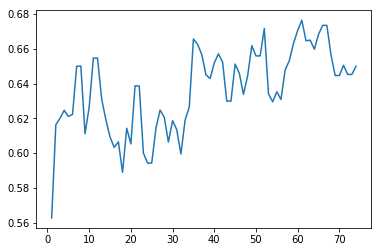

In [6]:
%matplotlib inline

ms = pd.Series(range(1, 75))
ms.index = range(1, 75)
ms.apply(choose_m).plot.line()
optimal_m = ms.apply(choose_m).idxmax()

We will now take our optimal value of m and find what the best value for k is, or the number of nearest neighbors we should use in our model.

In [7]:
tfidf = TfidfTransformer()
vec = CountVectorizer(max_features = optimal_m)

def choose_k(k):
    model = KNeighborsClassifier(n_neighbors=k)
    pipeline = Pipeline([
        ("vec", vec),
        ("tfidf", tfidf),
        ("model", model)
    ])
    return cross_val_score(pipeline, X_train, y_train, 
                cv=10, scoring="f1_weighted").mean() 


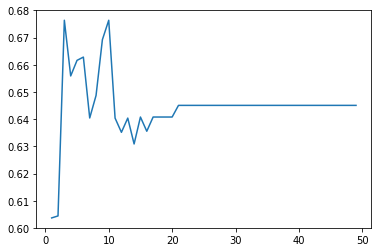

In [8]:
ks = pd.Series(range(1, 50))
ks.index = range(1, 50)
ks.apply(choose_k).plot.line()
optimal_k = ks.apply(choose_k).idxmax()

Now that we know the optimal value of m and k, we can train the ideal model to predict gender based on their dialogue from all of our data, and create a classification report.

In [9]:
train = justices_mini.sample(frac=0.5)
val = justices_mini.drop(train.index)

In [10]:
X_train = train["text_blocks"]
X_val = val["text_blocks"]
y_train = train["gender"]
y_val = train["gender"]

vec = CountVectorizer(max_features = optimal_m)
vec.fit(X_train)
X_train_vec = vec.transform(X_train)
X_val_vec = vec.transform(X_val)


tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_vec)
X_val_tfidf = tfidf.fit_transform(X_val_vec)

model = KNeighborsClassifier(n_neighbors = optimal_k)
model.fit(X_train_tfidf, y_train)

predictions = model.predict(X_val_tfidf)

In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

      female       0.33      0.13      0.19        15
        male       0.73      0.90      0.80        39

   micro avg       0.69      0.69      0.69        54
   macro avg       0.53      0.52      0.50        54
weighted avg       0.62      0.69      0.63        54



We managed to improve our weighted f1 score by about 0.06! It appears that using the top 65 words with 12 nearest neighbors to predict gender is a fairly good predictor. Let's see how this compares to a model using the statistics that we computed in our analysis as features. 

# Predicting Gender from Text and Sentiment Analysis Statistics

We will start by picking an arbitrary k value to create our base model, and calculating our initial cross validation weighted f1 score.

In [12]:
X_train = justices_mini[["interrupted", "first_modal", "duration", "sentiment", "sentiment_polarity", "subjectivity"]]
y_train = justices_mini["gender"]

In [13]:
##dummy encoding
x_train_dict = X_train.to_dict(orient = "records")
vec = DictVectorizer(sparse = False)

##standardizing
scaler = StandardScaler()

##model
model = KNeighborsClassifier(n_neighbors = 3)

In [14]:
pipeline = Pipeline([
    ("vec", vec),
    ("scaler", scaler),
    ("model", model)
])
cross_val_score(pipeline, x_train_dict, y_train, 
        cv=10, scoring="f1_weighted").mean()

0.652504469730476

We will now find the optimal k value using 10 fold cross validation with a weighted f1 score.

In [15]:
vec = DictVectorizer(sparse = False)
scaler = StandardScaler()

def choose_k(k):
    model = KNeighborsClassifier(n_neighbors=k)
    pipeline = Pipeline([
        ("vec", vec),
        ("scaler", scaler),
        ("model", model)
    ])
    return cross_val_score(pipeline, x_train_dict, y_train, 
                cv=10, scoring="f1_weighted").mean()

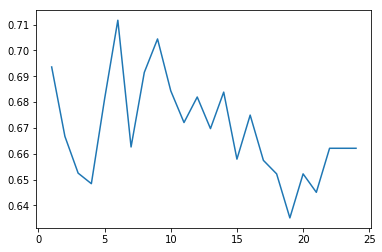

In [16]:
ks = pd.Series(range(1, 25))
ks.index = range(1, 25)
ks.apply(choose_k).plot.line()
optimal_k = ks.apply(choose_k).idxmax()

It appears that using 6 nearest neighbors produces the best weighted f1 score. Let's create our optimal model using cross validation on all of the data and create a classification report.

In [22]:
train = justices_mini.sample(frac=0.5)
val = justices_mini.drop(train.index)

In [24]:
X_train = train[["interrupted", "first_modal", "duration", "sentiment", "sentiment_polarity", "subjectivity"]]
X_val = val[["interrupted", "first_modal", "duration", "sentiment", "sentiment_polarity", "subjectivity"]]
y_train = train["gender"]
y_val = val["gender"]

x_train_dict = X_train.to_dict(orient = "records")
x_val_dict = X_val.to_dict(orient="records")


vec = DictVectorizer(sparse = False)
vec.fit(x_train_dict)
X_train_vec = vec.transform(x_train_dict)
X_val_vec = vec.transform(x_val_dict)


scaler = StandardScaler()
scaler.fit(X_train_vec)
X_train_sc = scaler.transform(X_train_vec)
X_val_sc = scaler.transform(X_val_vec)


model = KNeighborsClassifier(n_neighbors = optimal_k)
model.fit(X_train_sc, y_train)
predictions = model.predict(X_val_sc)

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

      female       0.33      0.25      0.29        16
        male       0.71      0.79      0.75        38

   micro avg       0.63      0.63      0.63        54
   macro avg       0.52      0.52      0.52        54
weighted avg       0.60      0.63      0.61        54



It looks like our analysis variables were much better at predicting gender than the raw text! We determined the optimal k and found the 10 fold cross validation weighted f1 score for different combinations of features and found that including all of the text and sentiment features yielded the highest weighted f1 score. It appears that whether or not a line was interrupted, whether or not the line started with a modal, the duration of the line, the sentiment of the line, the polarity of the line, and the subjectivity of the line were useful in predicting the gender of the justice who spoke that line. Let's see how good these features are at predicting the justice who spoke themself.

# Predicting Judge

We will now try to predict judge that spoke each line based on the text and sentiment analysis features that we created from the analysis. We will use features such as whether or not they were interrupted, if their line started with a modal, how long they spoke, their sentiment score, and their subjectivity score.

In [28]:
X_train = justices_mini[["interrupted", "first_modal", "duration", "sentiment", "sentiment_polarity", "subjectivity"]]
y_train = justices_mini["speaker"]

Let's pick some arbitrary values of k to start out with making our model.

In [29]:
##dummy encoding
x_train_dict = X_train.to_dict(orient = "records")
vec = DictVectorizer(sparse = False)

##standardizing
scaler = StandardScaler()

##model
model = KNeighborsClassifier(n_neighbors = 3)

In [30]:
pipeline = Pipeline([
    ("vec", vec),
    ("scaler", scaler),
    ("model", model)
])
cross_val_score(pipeline, x_train_dict, y_train, 
        cv=10, scoring="f1_weighted").mean()

0.15339774604480488

We will now determine the optimal value of k similarly to above.

In [31]:
vec = DictVectorizer(sparse = False)
scaler = StandardScaler()

def choose_k(k):
    model = KNeighborsClassifier(n_neighbors=k)
    pipeline = Pipeline([
        ("vec", vec),
        ("scaler", scaler),
        ("model", model)
    ])
    return cross_val_score(pipeline, x_train_dict, y_train, 
                cv=10, scoring="f1_weighted").mean()

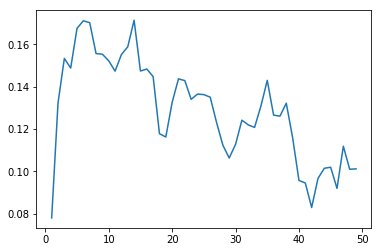

In [32]:
ks = pd.Series(range(1, 50))
ks.index = range(1, 50)
ks.apply(choose_k).plot.line()
optimal_k = ks.apply(choose_k).idxmax()

It appears that 49 is the optimal number of nearest neighbors to use for k. Let's now train our optimal model and use cross validation on all of the data to create a classification report. 

In [35]:
train = justices_mini.sample(frac=0.5)
val = justices_mini.drop(train.index)

In [36]:
X_train = train[["interrupted", "first_modal", "duration", "sentiment", "sentiment_polarity", "subjectivity"]]
X_val = val[["interrupted", "first_modal", "duration", "sentiment", "sentiment_polarity", "subjectivity"]]
y_train = train["speaker"]
y_val = val["speaker"]

x_train_dict = X_train.to_dict(orient = "records")
x_val_dict = X_val.to_dict(orient="records")


vec = DictVectorizer(sparse = False)
vec.fit(x_train_dict)
X_train_vec = vec.transform(x_train_dict)
X_val_vec = vec.transform(x_val_dict)


scaler = StandardScaler()
scaler.fit(X_train_vec)
X_train_sc = scaler.transform(X_train_vec)
X_val_sc = scaler.transform(X_val_vec)


model = KNeighborsClassifier(n_neighbors = optimal_k)
model.fit(X_train_sc, y_train)
predictions = model.predict(X_val_sc)

In [37]:
print(classification_report(y_val, predictions))

                      precision    recall  f1-score   support

  Anthony M. Kennedy       0.00      0.00      0.00         6
      Antonin Scalia       0.00      0.00      0.00        10
  Brett M. Kavanaugh       0.00      0.00      0.00         1
     David H. Souter       0.00      0.00      0.00         5
         Elena Kagan       0.00      0.00      0.00         2
John G. Roberts, Jr.       0.20      1.00      0.33         8
   John Paul Stevens       0.00      0.00      0.00         4
        Neil Gorsuch       0.00      0.00      0.00         1
 Ruth Bader Ginsburg       0.17      0.33      0.22         6
Samuel A. Alito, Jr.       0.00      0.00      0.00         1
     Sonia Sotomayor       0.00      0.00      0.00         4
   Stephen G. Breyer       0.00      0.00      0.00         6

           micro avg       0.19      0.19      0.19        54
           macro avg       0.03      0.11      0.05        54
        weighted avg       0.05      0.19      0.07        54



After trial and error with different combinations of features, we found that the highest weighted f1 score we could optain was around 0.16. Although we were dissapointed that our model was not great at predicting the justice after all of the analysis we conducted, we realized that in context, this is actually a good thing. 

The purpose of the supreme court is to be an unbiased group of people who interpret the constitution, and liberties of humans to determine what is right. If we were able to predict what justices spoke which lines, we may be able to predict what types of opinions justices will have or what kinds of questions they may ask, and people can then change how they argue in a way that may be advantageous to them. This hurts the integrity of our justice system. 

It is also not ideal for certain features to be good at predicting which justice spoke a line. If whether or not a judge was interrupted was useful in predicting the judge, this reveals that some judges are interrupted more often than others which is a sign that some judges may not be respected as much as others. Additionally, we do not want subjectivity to be a good predictor because judges should be somewhat evenly opinionated and keep their personal biases to that of what is written in the constitution. 

# Predicting Decisions From Text

We will now work with a new dataframe from the Supreme Court Data Base. Details on how we gathered and cleaned this dataset are in the data cleaning section. In this data frame called decisions, each row represents a unique judge case combination, or each judge at every case. It contains columns including which party won, whether or not the judge agrees with the majority, and everything that judge said during the case. We will use everything the judge said in the case to predict whether or not they agreed with the majority.

In [82]:
decisions = pd.read_csv("text-by-judge-and-case.csv")
decisions.head()

,docket_num,case_name,case_id,year,party_won,judge_decision,justice_name,text
0,09-559,Doe #1 v. Reed,22674,2009.0,defendant,majority,JGRoberts,We'll hear argument this morning in Case 09-55...
1,09-559,Doe #1 v. Reed,22674,2009.0,defendant,majority,JPStevens,Isn't there another-- --Isn't there another po...
2,09-559,Doe #1 v. Reed,22674,2009.0,defendant,majority,AScalia,What -- what about requiring disclosure of cam...
3,09-559,Doe #1 v. Reed,22674,2009.0,defendant,majority,AMKennedy,"Well, let me -- let me ask you, could the oppo..."
4,09-559,Doe #1 v. Reed,22674,2009.0,defendant,majority,RBGinsburg,But -- but don't you have -- I thought we were...


In [42]:
decisions_mini = decisions.sample(frac=0.25)

Let's start by training a model using arbitrary values for m and k and calculating the initial cross validation weighted f1 score. 

In [43]:
X_train = decisions_mini["text"]
y_train = decisions_mini["judge_decision"]

vec = CountVectorizer(max_features = 50)
model = KNeighborsClassifier(n_neighbors = 10)
tfidf = TfidfTransformer()

pipeline = Pipeline([
    ("vec", vec),
    ("tfidf", tfidf),
    ("model", model)
])

cross_val_score(pipeline, X_train, y_train, 
                cv=10, scoring="f1_weighted").mean() 


0.7196634008666705

Pretty good to start out! Let's now find the optimal value for the parameter m, or the number of words we will use in our vectorizer. 

In [44]:
tfidf = TfidfTransformer()
model = KNeighborsClassifier(n_neighbors=10)
def choose_m(m):
    vec = CountVectorizer(max_features = m)
    pipeline = Pipeline([
        ("vec", vec),
        ("tfidf", tfidf),
        ("model", model)
    ])
    return cross_val_score(pipeline, X_train, y_train, 
                cv=10, scoring="f1_weighted").mean() 

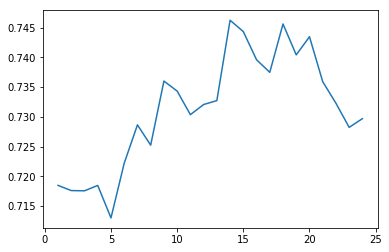

In [46]:
ms = pd.Series(range(1, 25))
ms.index = range(1, 25)
ms.apply(choose_m).plot.line()
optimal_m = ms.apply(choose_m).idxmax()

Now that we have the optimal value for m, let's find the optimal parameter for k, or the number of nearest neighbors we will use in our model.

In [47]:
tfidf = TfidfTransformer()
vec = CountVectorizer(max_features = optimal_m)

def choose_k(k):
    model = KNeighborsClassifier(n_neighbors=k)
    pipeline = Pipeline([
        ("vec", vec),
        ("tfidf", tfidf),
        ("model", model)
    ])
    return cross_val_score(pipeline, X_train, y_train, 
                cv=10, scoring="f1_weighted").mean() 


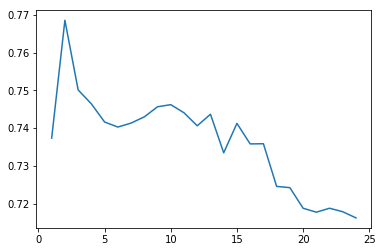

In [49]:
ks = pd.Series(range(1, 25))
ks.index = range(1, 25)
ks.apply(choose_k).plot.line()
optimal_k = ks.apply(choose_k).idxmax()

In [50]:
optimal_m, optimal_k

(14, 2)

Now that we have the optimal values for the parameters m and k, let's train the optimal model for these features and see how it does. 

In [51]:
train = decisions.sample(frac=0.5)
val = decisions.drop(train.index)

In [52]:
X_train = train["text"]
X_val = val["text"]
y_train = train["judge_decision"]
y_val = train["judge_decision"]

vec = CountVectorizer(max_features = optimal_m)
vec.fit(X_train)
X_train_vec = vec.transform(X_train)
X_val_vec = vec.transform(X_val)


tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_vec)
X_val_tfidf = tfidf.fit_transform(X_val_vec)

model = KNeighborsClassifier(n_neighbors = optimal_k)
model.fit(X_train_tfidf, y_train)

predictions = model.predict(X_val_tfidf)

In [53]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

    majority       0.81      0.94      0.87      1777
    minority       0.12      0.04      0.06       410

   micro avg       0.77      0.77      0.77      2187
   macro avg       0.47      0.49      0.46      2187
weighted avg       0.68      0.77      0.72      2187



Our model appears to be pretty good at predicting whether or not a judge will side with the majority based on the text of a judge! We had a lot of fun testing the predictions with different court cases, like United States v. Microsoft corportation and Obergefell v. Hodges. 

In [79]:
test_case1 = decisions[decisions.case_name == 'Microsoft v. Baker'].text
test_case2 = decisions[decisions.case_name == 'McCoy v. Louisiana'].text

X_train = decisions["text"]
y_train = decisions["judge_decision"]

vec = CountVectorizer(max_features = optimal_m)
vec.fit(X_train)
X_train_vec = vec.transform(X_train)
test_vec1 = vec.transform(test_case1)
test_vec2 = vec.transform(test_case2)


tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train_vec)
test_tfidf1 = tfidf.fit_transform(test_vec1)
test_tfidf2 = tfidf.fit_transform(test_vec2)

model = KNeighborsClassifier(n_neighbors = optimal_k)
model.fit(X_train_tfidf, y_train)

predictions1 = model.predict(test_vec1)
predictions2 = model.predict(test_vec2)

In [55]:
microsoft_outcome = (decisions[decisions.case_name == 'Microsoft v. Baker'].justice_name).to_frame()
microsoft_outcome["prediction"] = predictions1
microsoft_outcome["actual"] = decisions[decisions.case_name == 'Microsoft v. Baker'].judge_decision
microsoft_outcome

,justice_name,prediction,actual
3803,JGRoberts,majority,majority
3804,AMKennedy,majority,majority
3805,RBGinsburg,majority,majority
3806,SGBreyer,majority,majority
3807,SAAlito,majority,majority
3808,SSotomayor,majority,majority
3809,EKagan,majority,majority


Our model predicted 7/7 justices correctly!

In [80]:
mccoy_outcome = (decisions[decisions.case_name == 'McCoy v. Louisiana'].justice_name).to_frame()
mccoy_outcome["prediction"] = predictions2
mccoy_outcome["actual"] = decisions[decisions.case_name == 'McCoy v. Louisiana'].judge_decision
mccoy_outcome

,justice_name,prediction,actual
4145,JGRoberts,majority,majority
4146,AMKennedy,majority,majority
4147,RBGinsburg,majority,majority
4148,SGBreyer,majority,majority
4149,SAAlito,majority,minority
4150,SSotomayor,majority,majority
4151,EKagan,majority,majority
4152,NMGorsuch,majority,minority


Our model predicted 6/7 correctly, missing John G. Roberts. 

# Generating Lines By a Justice

We trained a unigram Markov Chain to generate dialogue that a justice says during a given turn. Because some of the lines are quite short, we found that using a unigram produced more unique and interesting lines than a bigram model. Below are the functions train_markov_chain and generate_new_dialogue that we used to create new dialogue

In [57]:
def train_markov_chain(turns):
    chain = {"<START>": []}
    for turn in turns:
        for i in range(len(turn)):
            word = turn[i]
            if chain.get(word)== None:
                if (i+1) < len(turn):
                    chain[word] = [turn[i+1]]
            else:
                if (i+1) < len(turn):
                    chain[word].append(turn[i+1])
        
        
    return chain

In [58]:
import random

def generate_new_dialogue(chain):
    words = []
    word = random.choice(chain["<START>"])
    words.append(word)
    while word != "<END>":
        word = random.choice(chain[word])
        words.append(word)

    dialogue = " ".join(words[:-1])
    return "\n".join(dialogue.split("<N>"))

As Sonia Sotomayor fans, we naturally generated dialogue based on everything she has said in a Supreme Court Case since 2005.

In [59]:
ss_text = []
ss = justices[justices.speaker == "Sonia Sotomayor"]
for i in range(len(ss)):
    ss_text.append(ss.iloc[i].text_blocks)

In [60]:
for i in range(len(ss_text)):
    case = ss_text[i]
    case = "<START> " + case + " <END>"
    case = case.split()
    ss_text[i] = case

In [61]:
chain = train_markov_chain(ss_text)

In [63]:
generate_new_dialogue(chain)

'So basically all claims, does it is. The first type of this statute, injunctive relief.'